# This exercise will focus on training a linear classifier for the MNIST dataset.

1.   NAME: NITYASH GAUTAM
2.   SID: 862395403
3.   UCR MAIL ID: ngaut006@ucr.edu

## Importing Essentials

In [1]:
import torch
print(torch.__version__)
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random

2.0.0+cu118


## Main Assignment Tasks Begin

### **TASK 1**: (2 pts)
Write the code for downloading and formatting the data.

In [2]:
# Converting From PIL to tensors and Normalize
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [3]:
# Download MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform = transform)
print('train_set Length', len(trainset))
print('test_set Length', len(testset))

100%|██████████| 9912422/9912422 [00:00<00:00, 67507722.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77353572.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23715096.83it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13895352.86it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



train_set Length 60000
test_set Length 10000


#### **Input**: Each input x is a 28 × 28 matrix. Convert inputs x to vectors of size 784.

In [4]:
# Converting x and y to vectors of the specified lengths (n,784) & (n,1) for TRAINING SET
x_train = []
y_train = []

for img, label in trainset:
  x_train.append(img.squeeze().view(-1))
  y_train.append(int(label))

x_train = torch.stack(x_train, dim=0)
y_train = torch.tensor(y_train)

print('Size of x_train = ', x_train.shape)
print('Size of y_train = ', y_train.shape)

Size of x_train =  torch.Size([60000, 784])
Size of y_train =  torch.Size([60000])


In [5]:
# Converting x and y to vectors of the specified lengths (n,784) & (n,1) for TESTING SET
x_test = []
y_test = []

for img, label in testset:
  x_test.append(img.squeeze().view(-1))
  y_test.append(int(label))

x_test = torch.stack(x_test, dim=0)
y_test = torch.tensor(y_test)

# Logs to validate the operations
print('Size of x_test = ', x_test.shape)
print('Size of y_test = ', y_test.shape)

Size of x_test =  torch.Size([10000, 784])
Size of y_test =  torch.Size([10000])


#### **Output**: Each label y is a digit from 0 to 9. Apply one-hot encoding on y and convert it to a vector $y^{oh}$ of size 10.

In [6]:
# Function to convert the output (labels) to onehot encoded vectors
def one_hot(labels):
  x = torch.unique(labels)
  onehot_vector = torch.zeros((labels.shape[0], x.shape[0]))
  onehot_vector[torch.arange(labels.shape[0]), labels.int()] = 1

  return onehot_vector

In [7]:
# performing the onehot encoding operation
y_test_onehot = one_hot(y_test)
y_train_onehot = one_hot(y_train)

# Logs validating the operations
print(y_train_onehot.shape)
print(y_train_onehot[0])

print(y_test_onehot.shape)
print(y_test_onehot[0])

torch.Size([60000, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
torch.Size([10000, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


### **TASK 2**: (5 pts) 
Write the code for minibatch SGD implementation for your linear MNIST classifier.

#### Helper Functions

In [8]:
# The Loss function calculating the Quadratic loss 
def quadratic_loss(onehot_y_pred: torch.Tensor, onehot_y_true: torch.Tensor) -> torch.Tensor:
  """
  Input: 
    onehot_y_pred: The prediction given by the model in the form of a onehot encoded vector
    onehot_y_true: The true label from the dataset in the form of a onehot encoded vector

  Output:
    Computed squared loss as a scalar tensor
  """
  return torch.sum(0.5*(onehot_y_pred - onehot_y_true) ** 2) / onehot_y_pred.shape[0]

In [9]:
# Forward Pass Function
def forward_pass(X: torch.Tensor, w: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
  """
  Performs a forward pass through a linear layer.

  Input:
      X (torch.Tensor): Input tensor of shape (batch_size, input_size)
      w (torch.Tensor): Weight tensor of shape (output_size, input_size)
      b (torch.Tensor): Bias tensor of shape (output_size,)

  Output:
      y (torch.Tensor): Output tensor of shape (batch_size, output_size)
  """
  y = torch.matmul(X, w.T) + b

  return y

In [10]:
# Function to calculate accuracy
def compute_accuracy(true_y: torch.Tensor, onehot_output_y: torch.Tensor) -> torch.Tensor:
  """
    Computes the accuracy of a model's predictions.

    Input:
      true_y (torch.Tensor): The ground-truth labels of the data. Shape (batch_size,)
      onehot_output_y (torch.Tensor): The predicted probabilities of each class. Shape (batch_size, num_classes)

    Output:
      accuracy (torch.Tensor): The fraction of correct predictions.
    """
  accuracy = torch.sum(torch.argmax(onehot_output_y, dim = 1) == true_y) / true_y.shape[0]
  return accuracy

In [11]:
def loss_plot(loss_array: list[int]) -> None:
  """
  Plots the training loss over the iterations.

  Inputs:
    loss_array (list[int]): The computed loss values over the iterations.

  Returns:
    None
  """

  with torch.no_grad():
    plt.figure(1)
    plt.plot(torch.arange(0,len(loss_array)), loss_array)
    plt.title('Plot of TRAINING LOSS vs ITERATIONS')
    plt.xlabel('ITERATIONS')
    plt.ylabel('COMPUTED LOSS')
    plt.grid()
    plt.show()

In [12]:
def accuracy_plot(train_accuracy: list[int], test_accuracy: list[int]) -> None:
  """
  Plots the training and test accuracies over the iterations.

  Inputs:
    train_accuracy (list[int]): The computed accuracy values over the iterations for the training set.
    test_accuracy (list[int]): The computed accuracy values over the iterations for the test set.

  Returns:
    None
  """
  with torch.no_grad():
    plt.figure(2)
    plt.plot(torch.arange(0,len(train_accuracy)), train_accuracy,label='train')
    plt.plot(torch.arange(0,len(test_accuracy)), test_accuracy,label='test')
    plt.title('Plot of ACCURACIES vs ITERATIONS')
    plt.xlabel('ITERATIONS')
    plt.ylabel('ACCURACIES')
    plt.legend()
    plt.grid()
    plt.show()

#### Main Function

In [13]:
# Implementation of the linear classsifier for the MNIST Dataset

def run_classifier(x_training, true_y_training, onehot_y_training, x_testing, true_y_testing, onehot_y_testing, lr, n_epochs, n_iters, batch_size):
  """
  Trains a linear classifier for the MNIST dataset.

  Args:
    x_training: Training data.
    true_y_training: Ground truth labels for the training data.
    onehot_y_training: One-hot encoded ground truth labels for the training data.
    x_testing: Testing data.
    true_y_testing: Ground truth labels for the testing data.
    onehot_y_testing: One-hot encoded ground truth labels for the testing data.
    lr: Learning rate.
    n_epochs: Number of epochs to train for.
    n_iters: Number of iterations per epoch.
    batch_size: Batch size to use during training.

  Returns:
    array_of_losses: Array of computed losses.
    array_of_train_acc: Array of computed training accuracies.
    array_of_test_acc: Array of computed testing accuracies.
  """
  
  w = torch.zeros((y_train_onehot.shape[1], x_test.shape[1]))
  b = torch.zeros(1,1)

  array_of_losses = []
  array_of_train_acc = []
  array_of_test_acc = []

  for epoch in range(n_epochs):
      
    for iter in range(n_iters):
      
      # Generating random indices as per the Batch Size
      random_indices = torch.randint(x_training.shape[0],(batch_size,))
      
      # Performing the forward pass operation that yeilds an output y as x.WT+b
      output = forward_pass(x_training[random_indices], w, b)
      
      # Computing the quadratic loss after recieving an output from the forward pass operation
      l = quadratic_loss(output, onehot_y_training[random_indices])
      
      # Performning the backPropagation operation: yeilds the gradients of w and b
      grad_w = torch.matmul((output - onehot_y_training[random_indices]).T,x_training[random_indices]) / output.shape[0]
      grad_b = torch.sum(output - onehot_y_training[random_indices]) / output.shape[0]
      
      # Updating the weights and Biases
      w = w - lr*grad_w
      b = b - lr*grad_b
    
    # Performing the forward pass on the complete dataset
    output = forward_pass(x_training, w, b)

    # Loss computation with respect to the complete dataset
    l = quadratic_loss(output, onehot_y_training)
    # Adding individual losses to one array
    array_of_losses.append(l)

    # Computing the Training accuracies
    train_acc = compute_accuracy(true_y_training, output)
    array_of_train_acc.append(train_acc.item())

    # Computing the Test accuracies
    test_output = forward_pass(x_test, w, b)
    test_acc = compute_accuracy(true_y_testing, test_output)
    array_of_test_acc.append(test_acc.item())
  
  return array_of_losses, array_of_train_acc, array_of_test_acc

#### Testing the Built Classifier

In [14]:
# Fixing the classifier's parameters
lr = 0.001
epochs = 50
iters = 100
b = 100

In [15]:
# Running the Classifier
losses,train_acc, test_acc = run_classifier(x_train, y_train,y_train_onehot,x_test, y_test, y_test_onehot, lr, epochs, iters, b)

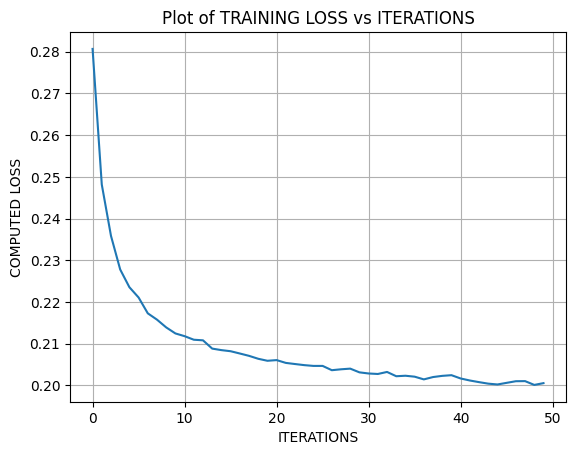

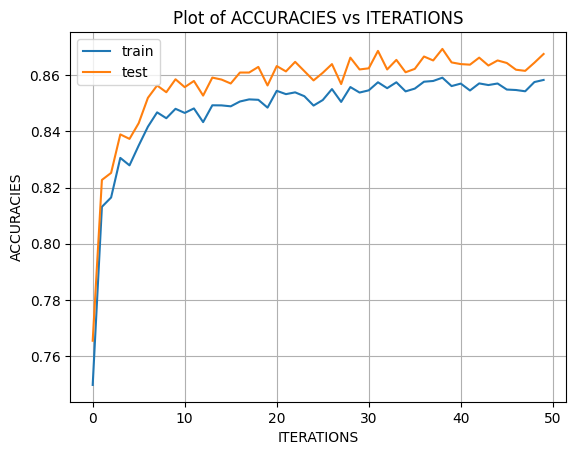

 
****************************************************************************************************
 
Training Loss =  tensor(0.2001)
Training Accuracy =  0.8590666651725769
Test Accuracy =  0.8693000078201294


In [16]:
# Plotting the loss and accuracy curves with respect to iterations
loss_plot(losses)
accuracy_plot(train_acc, test_acc)
print(" ")

print("*"*100)

print(" ")
print("Training Loss = ", min(losses))
print("Training Accuracy = ",max(train_acc))
print("Test Accuracy = ",max(test_acc))

metrics_scratch = {'Implementation': 'Scratch', 'Training loss': min(losses), 'Training Accuracy': max(train_acc), 'Test Accuracy': max(test_acc)}

### **TASK 3**: (7 pts) 
**The role of batch size:** Run your code with batch sizes B = [1, 10, 100, 1000]. For each batch size,

*   Determine a good choice of Learning Rate
*   Pick ITR sufficiently large to ensure the (approximate) convergence of the training loss
*   Plot Progress of Training loss (y-axis) as a function of the iteration counter t (x-axis)
*   Report how long does the training takes
*   Plot Progress of the test accuracy (y-axis) as a function of the iteration counter t (x-axis)



#### Main Code

For batch size =  1  and learning Rate =  0.001 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  9.792964458465576 s
 


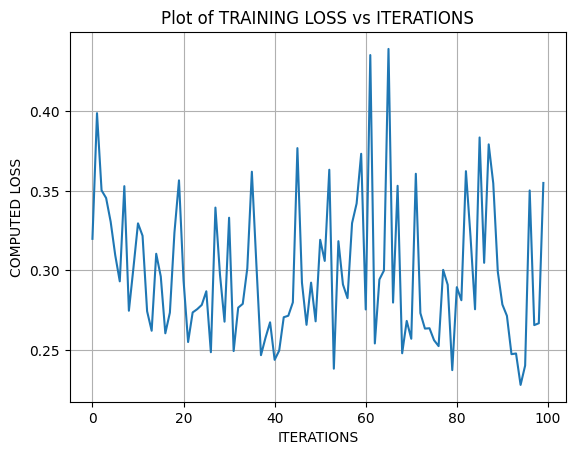

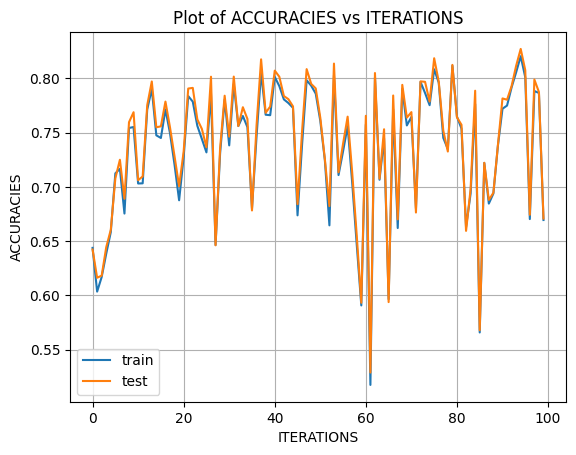

 
****************************************************************************************************
 
For batch size =  10  and learning Rate =  0.001 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  10.006179809570312 s
 


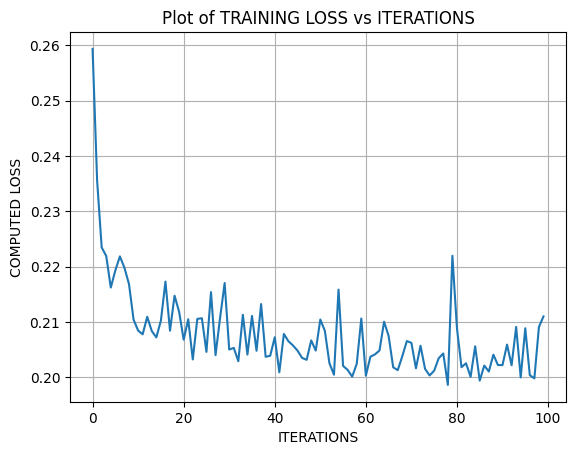

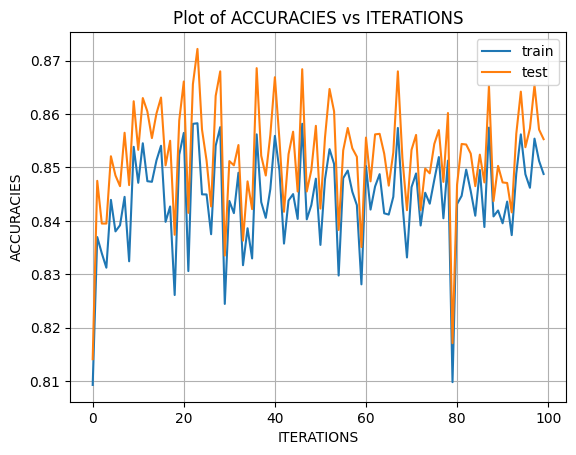

 
****************************************************************************************************
 
For batch size =  100  and learning Rate =  0.001 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  14.954327583312988 s
 


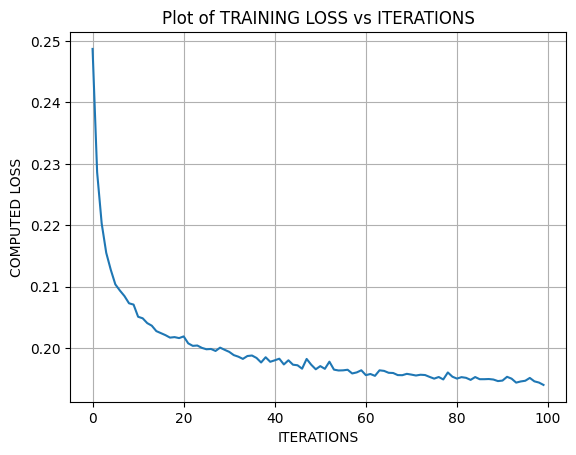

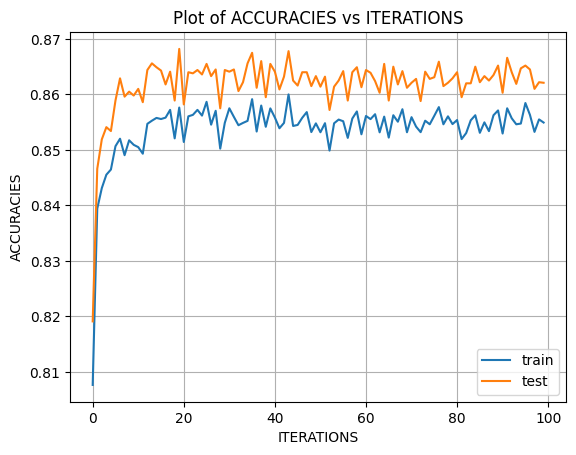

 
****************************************************************************************************
 
For batch size =  1000  and learning Rate =  0.001 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  61.550790548324585 s
 


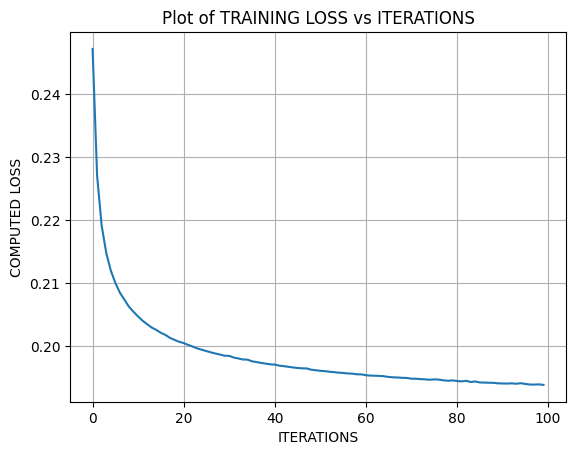

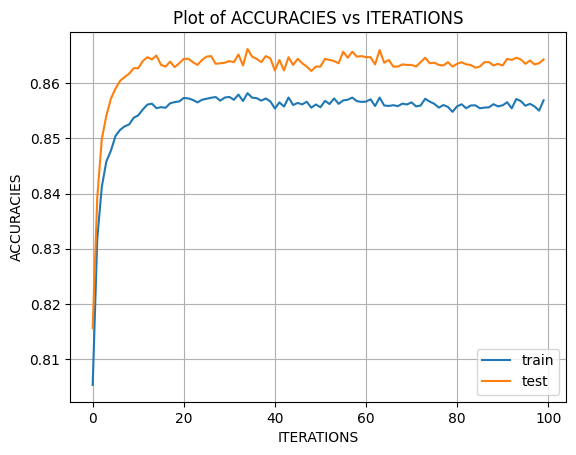

 
****************************************************************************************************
 


In [17]:
# Creating an array of different batch Sizes
b = [1,10,100,1000]

# Fixing the other parameters of the Classifier
lr = 0.001
epochs = 100
iters = 200

# Initializing an array that will store multiple metrics of the classifier after the execution
observations = []

# Iterating the classifier over every value of batch_size
for batch in b:
  
  t0 = time.time()
  
  losses,train_acc, test_acc = run_classifier(x_train, y_train,y_train_onehot,x_test, y_test, y_test_onehot, lr, epochs, iters, batch)
  
  t1 = time.time()

  print("For batch size = ", batch," and learning Rate = ", lr, ", below are the results")
  print("-"*100)
  print("Training Time = ", t1-t0, "s")
  
  print(" ")
  
  loss_plot(losses)
  accuracy_plot(train_acc, test_acc)
  
  print(" ")
  
  print("*"*100)
  print(" ")

  #  A dictionary that maps multiple metrics of the classifier's performance to their values
  individual_summary = {'Batch Size': batch, 'Training Loss': min(losses),'Training Accuracy': max(train_acc*100), 'Testing Accuracy': max(test_acc*100), 'Training Time': t1-t0}

  # Appending the metrics of every batch size execution to create a dataframe
  observations.append(individual_summary)

#### Observed Results

In [18]:
# Creating a DataFrame of all the observed Metrics
cumulative_observations = pd.DataFrame.from_records(observations)
print("Observed results with different Batch Sizes and learning Rate = 0.001")
cumulative_observations

Observed results with different Batch Sizes and learning Rate = 0.001


,Batch Size,Training Loss,Training Accuracy,Testing Accuracy,Training Time
0,1,tensor(0.2281),0.820300,0.8270,9.792964
1,10,tensor(0.1986),0.858283,0.8722,10.006180
2,100,tensor(0.1940),0.860000,0.8682,14.954328
3,1000,tensor(0.1938),0.858183,0.8662,61.550791


### **TASK 4**: 
Comment on the role of batch size.

As seen in the above observations, an increase in batch size yeilds us positive results. 

The training loss moves more towards convergence. The Training and Test Accuracies also increases.

### **TASK 5**: : (6 pts) 
**The role of training dataset size:** Let us reduce the training dataset size. Instead of N = 50, 000, let us pick a subset S′ of size N′ from the original dataset without replacement and uniformly at random. Fix batch size to B = 100. Repeat the steps above for N′ ∈ {100, 500, 1000, 10000}. Comment on the accuracy as a function of dataset size.

#### Main Code

For batch size =  100  and dataset size =  100 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  7.92406964302063 s
 


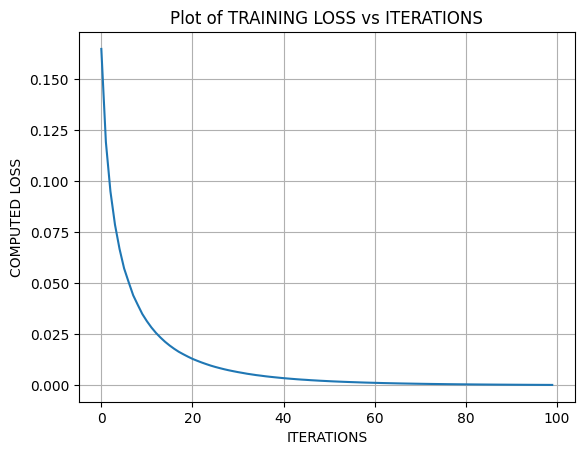

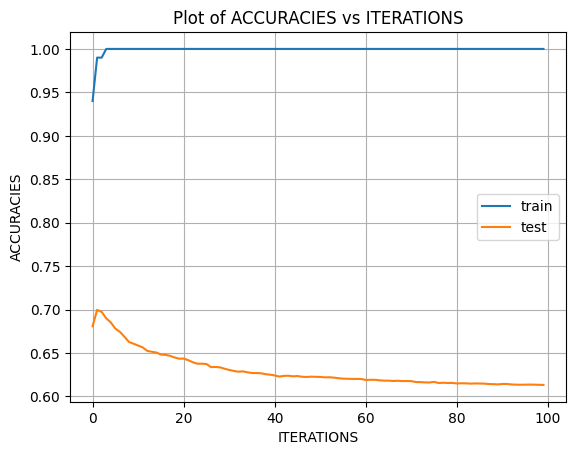

 
****************************************************************************************************
 
For batch size =  100  and dataset size =  500 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  10.531812906265259 s
 


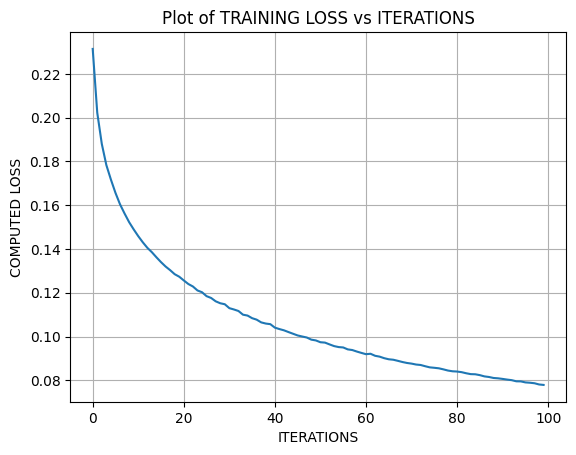

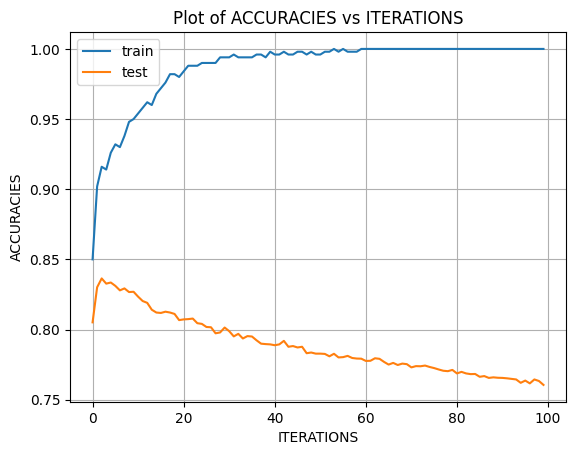

 
****************************************************************************************************
 
For batch size =  100  and dataset size =  1000 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  9.731715679168701 s
 


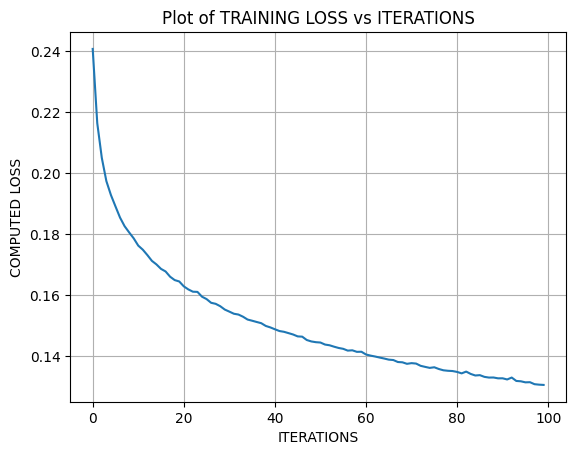

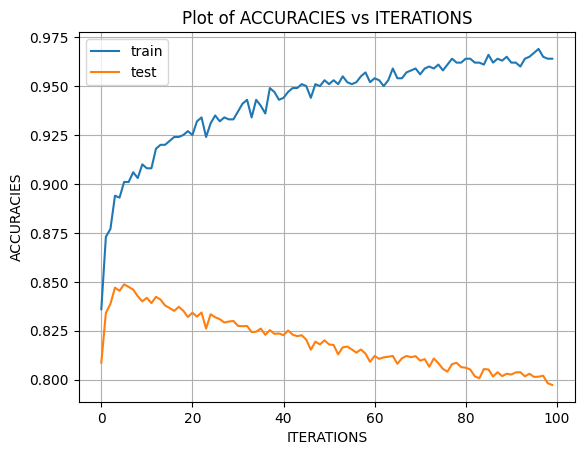

 
****************************************************************************************************
 
For batch size =  100  and dataset size =  10000 , below are the results
----------------------------------------------------------------------------------------------------
Training Time =  11.295932054519653 s
 


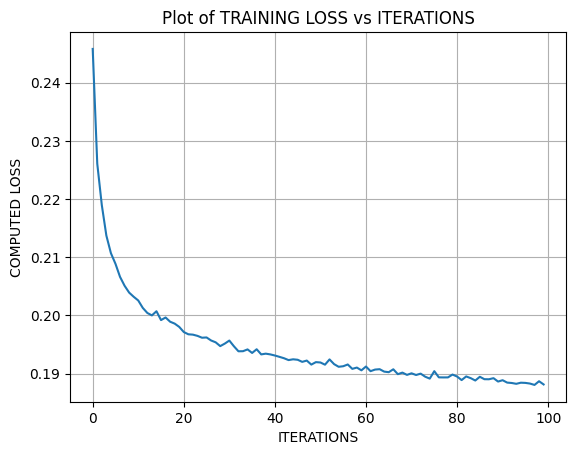

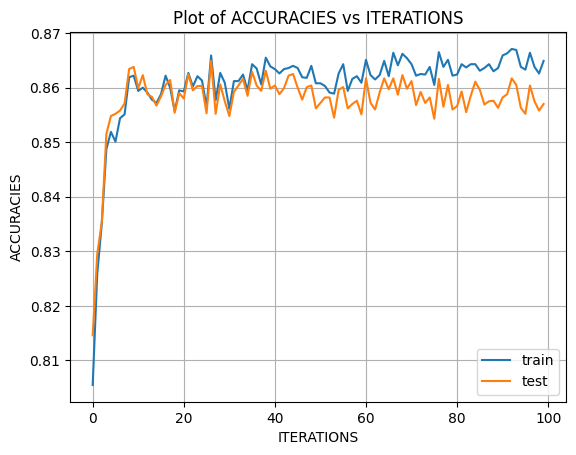

 
****************************************************************************************************
 


In [19]:
# Creating an array of different Subset Sizes
N = [100, 500, 1000, 10000]

# Fixing the other parameters of the Classifier
lr = 0.001
epochs = 100
iters = 200
batch_size = 100

# Initializing an array that will store multiple metrics of the classifier after the execution
observations = []

# Iterating the Classifier over every value of Subset Size
for size in N:
  t0 = time.time()

  # Onehot Encoding the train and test labels from the original Dataset
  y_train_onehot_ss = one_hot(y_train)
  y_test_onehot_ss = one_hot(y_test)

  # Generating Random Indiced
  random_indices = torch.randperm(y_train_onehot_ss.shape[0])[:size]
  
  losses,train_acc, test_acc = run_classifier(x_train[random_indices], y_train[random_indices], y_train_onehot_ss[random_indices], x_test, y_test, y_test_onehot_ss, lr, epochs, iters, batch_size)
  t1 = time.time()

  print("For batch size = ", batch_size, " and dataset size = ", size, ", below are the results")
  print("-"*100)
  print("Training Time = ", t1-t0, "s")
  
  print(" ")

  loss_plot(losses)
  accuracy_plot(train_acc, test_acc)

  print(" ")
  
  print("*"*100)
  print(" ")

  #  A dictionary that maps multiple metrics of the classifier's performance to their values
  individual_summary = {'Subset Size': size, 'Training Loss': min(losses),'Training Accuracy': max(train_acc*100), 'Testing Accuracy': max(test_acc*100), 'Training Time': t1-t0}

  # Appending the Metrics of every Subset Size execution to create a Dataframe
  observations.append(individual_summary)

#### Observed Results

In [20]:
# Creating a DataFrame of all the observed Metrics
cumulative_observations = pd.DataFrame.from_records(observations)
print("Observed results with different Subset Size")
cumulative_observations

Observed results with different Subset Size


,Subset Size,Training Loss,Training Accuracy,Testing Accuracy,Training Time
0,100,tensor(0.0003),1.0000,0.6996,7.924070
1,500,tensor(0.0779),1.0000,0.8364,10.531813
2,1000,tensor(0.1307),0.9690,0.8487,9.731716
3,10000,tensor(0.1881),0.8671,0.8649,11.295932


### **TASK 6**: : (Bonus 5 pts) 
**Simpler Life**: Run the linear MNIST classifier with batchsize B = 100 over the full dataset by using PyTorch or Tensorflow. Use same learning rate and initialization W0 = 0. Verify that it is consistent with your handcoded algorithm by comparing your results (the accuracy and training loss plots).

#### Main Function

In [21]:
def torch_classifier(x_training, y_training, x_testing, y_testing, classifier_model, loss_criterion, optimizer, n_epochs, n_iters, batch_size):
  with torch.no_grad():
    classifier_model.weight.zero_()
    classifier_model.bias.zero_()

  onehot_y_train = one_hot(y_training)

  array_of_losses = []
  array_of_train_acc = []
  array_of_test_acc = []
  
  for epoch in range(n_epochs):
    for iter in range(n_iters):

      # Generating Random indices as per the Batch Size
      random_batch_indices = torch.randint(x_training.shape[0],(batch_size,))

      # Performing the forward pass operation that yeilds an output y as x.WT+b
      output = classifier_model(x_training[random_batch_indices])

      # Computing the quadratic loss after recieving an output from the forward pass operation
      loss = loss_criterion(output, onehot_y_train[random_batch_indices])

      # Performning the backPropagation operation: yeilds the gradients of w and b
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    with torch.no_grad():
      # train loss on complete dataset
      output = classifier_model(x_training)
      training_loss = loss_criterion(output, onehot_y_train)
      array_of_losses.append(training_loss)
      # train accuracy
      array_of_train_acc.append(compute_accuracy(y_training, output))
      # test accuracy
      output = classifier_model(x_testing)
      array_of_test_acc.append(compute_accuracy(y_testing, output))

  # plot graphs
  loss_plot(array_of_losses)
  accuracy_plot(array_of_train_acc, array_of_test_acc)

  max_train_acc = max(array_of_train_acc)*100
  max_test_acc = max(array_of_test_acc)*100
  min_loss = min(array_of_losses)
  print(" ")

  print("*"*100)

  print(" ")
  print("Training Loss = ", min_loss)
  print("Training Accuracy = ", max_train_acc)
  print("Test Accuracy = ", max_test_acc)

  metrics = {'Implementation': 'PyTorch', 'Training loss': min(losses), 'Training Accuracy': max(train_acc), 'Test Accuracy': max(test_acc)}

  return metrics

#### Defining Multiple Parameters

In [22]:
# Defining the Model
classifier_model = torch.nn.Linear(784, 10, bias=True)

# Defining the Loss Criterion
loss_criterion = torch.nn.MSELoss()

# Setting the optimizer to SGD
sgd = torch.optim.SGD(classifier_model.parameters(), lr=0.001)

# Fixing other Classifer Parameters
batch_size = 100
n_epochs = 50
n_iters = 100

#### Running and Testining The Classsifier

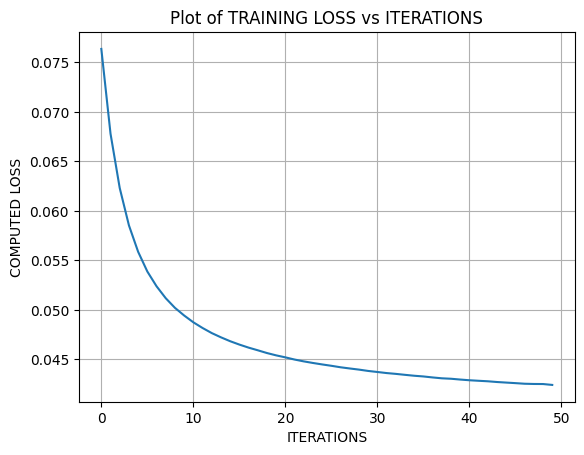

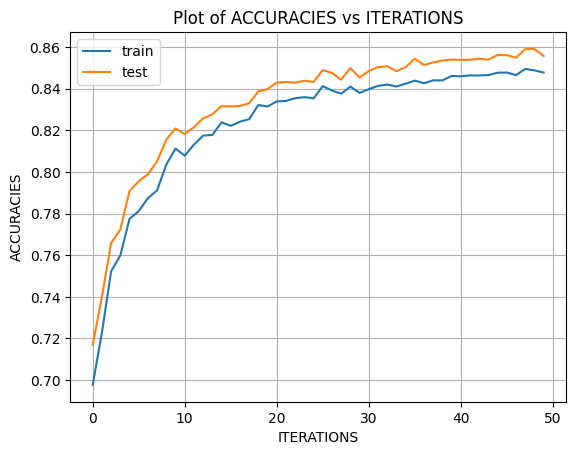

 
****************************************************************************************************
 
Training Loss =  tensor(0.0424)
Training Accuracy =  tensor(84.9483)
Test Accuracy =  tensor(85.9100)


In [23]:
# Running the PyTorch Classifier
metrics_pytorch = torch_classifier(x_train, y_train, x_test, y_test, classifier_model, loss_criterion, sgd, n_epochs, n_iters, batch_size)

#### Comparison of Scratch Code vs PyTorch Implementation

In [24]:
print(metrics_scratch)
print(metrics_pytorch)

{'Implementation': 'Scratch', 'Training loss': tensor(0.2001), 'Training Accuracy': 0.8590666651725769, 'Test Accuracy': 0.8693000078201294}
{'Implementation': 'PyTorch', 'Training loss': tensor(0.1881), 'Training Accuracy': 0.8671000003814697, 'Test Accuracy': 0.8648999929428101}


In [25]:
data = [metrics_scratch, metrics_pytorch]
final_comparison = pd.DataFrame(data)
final_comparison

,Implementation,Training loss,Training Accuracy,Test Accuracy
0,Scratch,tensor(0.2001),0.859067,0.8693
1,PyTorch,tensor(0.1881),0.867100,0.8649


The above table shows the difference between the performance of the linear classifier which is code from scratch and the one coded using PyTorch.

# Submission

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended

In [ ]:
!jupyter nbconvert --log-level CRITICAL --to pdf Nityash_Gautam_Assignment_1.ipynb # make sure the ipynb name is correct